# Big Data in Finance: Part II <BR><BR> Lecture Notes 10: Merge CRSP and Compustat 
   
**Instructor** <BR>
Lira Mota, lmota20@gsb.columbia.edu
    
**TA's:** <BR>
Daheng Yang, dyang22@gsb.columbia.edu

**Objective:** <BR>
    
Create a final data set called "stock_annual" that has both crsp (permno/permco) and compustat (gvkey) identifiers.

## Query CRSP/Compustat merged table (annual or quarterly).

1. Output table is CRSP-centric with permno-datadate being the primary key.
2. Fiscal period end date must be within link date range.
3. WRDS SAS code can be found [here](https://wrds-web.wharton.upenn.edu/wrds/support/Data/_003Sample%20Programs/CRSP/index.cfm?).

## Set Up

In [1]:
#%% Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 100) # max number or rows to be displayed 
%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
db = wrds.Connection(wrds_username='lmota')  # make sure to configure wrds connector before hand.

Loading library list...
Done


## Many Linking Tables

In [3]:
crsp_tables = db.list_tables(library="crspq") # compd: Compustat daily update
pd.DataFrame({'tables':crsp_tables}) # Transform libs to a Pandas data frame to have a better display.

tables
0               acti
1               asia
2               asib
3               asic
4               asio
..               ...
238         yldave12
239         yldbid06
240         yldbid12
241  ziman_reit_info
242      zr_hdrnames

[243 rows x 1 columns]

**CCMXPF_LNKHIST - Link History**


* CCMXPF_LNKHIST contains the historical and current links between GVKEY and LPERMNO/LPERMCO (previously known as NPERMN O/NPERMCO in old version CCM). 


* In addition, it includes the beginning and ending dates for links, the link types, and the primary issue marker, and liid codes (Compustat's secondary ID variable, IID).

[Source](https://wrds-www.wharton.upenn.edu/pages/support/research-wrds/research-guides/ccm-sas-datasets/)

## Many Linking Types

In [4]:
db.describe_table(library="crspq", table="ccmxpf_lnkhist")

Approximately 103457 rows in crspq.ccmxpf_lnkhist.


name  nullable              type
0      gvkey      True        VARCHAR(6)
1   linkprim      True        VARCHAR(1)
2       liid      True        VARCHAR(3)
3   linktype      True        VARCHAR(2)
4    lpermno      True  DOUBLE PRECISION
5    lpermco      True  DOUBLE PRECISION
6     linkdt      True              DATE
7  linkenddt      True              DATE

LINKPRIM: Primary issue marker for the link.

## Download Data

In [5]:
sql = '''SELECT gvkey, lpermno as permno, lpermco as permco, linktype, linkdt, linkenddt
         FROM crspq.ccmxpf_lnkhist
         WHERE linktype IN ('LC', 'LU', 'LS') 
      ''' 

link_table = db.raw_sql(sql, date_cols=['linkdt', 'linkenddt'])

In [8]:
compa = pd.read_pickle('/Users/liramertens/Dropbox/Columbia/BigData/class2020/lecture_outputs/compa_annual.pkl')

## Understading Linking Table

In [10]:
link_table[link_table.permco==54311]

gvkey   permno   permco linktype     linkdt  linkenddt
14509  017010  13757.0  54311.0       LC 2013-01-14 2016-04-17
14510  017010  13758.0  54311.0       LC 2013-01-14 2016-04-15
14511  017010  14811.0  54311.0       LC 2014-07-24 2016-04-17
14512  017010  15998.0  54311.0       LC 2016-04-18 2017-12-31
14513  017010  15998.0  54311.0       LC 2018-01-01        NaT
14514  017010  15999.0  54311.0       LC 2016-04-16        NaT
14515  017010  16000.0  54311.0       LC 2016-04-18 2017-12-31
14516  017010  16000.0  54311.0       LC 2018-01-01        NaT
18983  027186  15996.0  54311.0       LC 2016-04-18 2017-12-31
18984  027186  15996.0  54311.0       LC 2018-01-01        NaT
18985  027186  15997.0  54311.0       LC 2016-04-18 2017-12-31
18986  027186  15997.0  54311.0       LC 2018-01-01        NaT
18987  027187  13757.0  54311.0       LS 2016-04-18 2017-12-31
18988  027187  13757.0  54311.0       LS 2018-01-01        NaT
18989  027187  14811.0  54311.0       LS 2016-04-18 2017-12-31
18990  027187  14811.0  54311.0       LS 2018-01-01        NaT

## Merge and Link

* Link type code. Each link is given a code describing the connection between the CRSP and Compustat data. 

* Values are:

    * LC – Link research complete. Standard connection between databases.
    * LU – Unresearched link to issue by CUSIP
    * LS – Link valid for this security only. Other CRSP PERMNOs with the same PERMCO will link to other GVKEYs.
    * LX – Link to a security that trades on another exchange system not included in CRSP data.
    * LD – Duplicate Link to a security. Another GVKEY/IID is a better link to that CRSP record.
    * LN – Primary link exists but Compustat does not have prices.
    * NR – No link available, confirmed by research
    * NU – No link available, not yet confirmed

In [11]:
link_table.linktype.value_counts()

LU    16236
LC    13760
LS     3316
Name: linktype, dtype: int64

In [12]:
df = pd.merge(compa, link_table, on=['gvkey'], how='inner') 

In [ ]:
df[]

In [13]:
df = df[(df.datadate >= df.linkdt) | (df.linkdt.isnull())]
df = df[(df.datadate <= df.linkenddt) | (df.linkenddt.isnull())]

In [14]:
df['permno'] = df['permno'].astype(int)
df['permco'] = df['permco'].astype(int)
df['datadate'] = pd.to_datetime(df['datadate'])

In [15]:
df.shape

(255770, 53)

In [16]:
compa.shape

(397671, 48)

In [18]:
df.duplicated(subset=['permco', 'datadate']).sum()

15146

In [20]:
 compa.groupby(['fyear']).gvkey.nunique()

fyear
1980.0     6889
1981.0     7058
1982.0     7685
1983.0     7996
1984.0     8243
1985.0     8599
1986.0     9017
1987.0     9225
1988.0     9333
1989.0     9343
1990.0     9571
1991.0     9966
1992.0    10705
1993.0    11482
1994.0    11899
1995.0    12492
1996.0    12624
1997.0    12438
1998.0    12555
1999.0    12531
2000.0    12093
2001.0    11584
2002.0    11251
2003.0    11064
2004.0    10897
2005.0    10854
2006.0    10881
2007.0    10981
2008.0    10862
2009.0    10834
2010.0    11074
2011.0    11683
2012.0    11871
2013.0    11804
2014.0    11560
2015.0    11255
2016.0    10747
2017.0     6725
Name: gvkey, dtype: int64

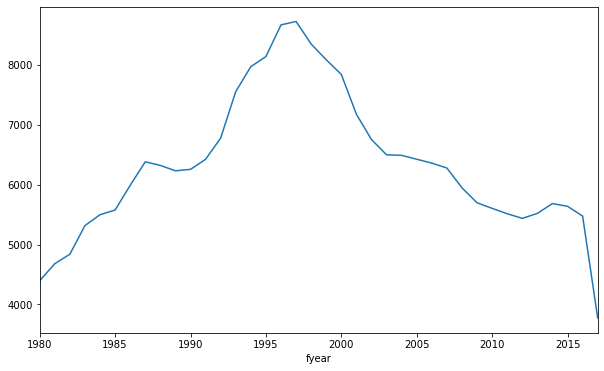

In [22]:
 df.groupby(['fyear']).permco.nunique().plot()

## Special Cases

### Many PERMCOs for One GVKEY

In [23]:
df.groupby('gvkey').permco.nunique().max()

4

In [24]:
df.loc[df.gvkey==df.groupby('gvkey').permco.nunique().idxmax(), ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']]

datadate  permno  permco   gvkey   conm         at
288122 1995-12-31   81875    4388  032280  STARZ   2517.636
288129 1996-12-31   81875    4388  032280  STARZ   3058.952
288136 1997-12-31   81875    4388  032280  STARZ   5038.561
288143 1998-12-31   81875    4388  032280  STARZ  20348.000
288151 1999-12-31   86746   20103  032280  STARZ  58684.000
288158 2000-12-31   86746   20103  032280  STARZ  54268.000
288166 2001-12-31   89130   41998  032280  STARZ  48539.000
288173 2002-12-31   89130   41998  032280  STARZ  39685.000
288180 2003-12-31   89130   41998  032280  STARZ  54013.000
288187 2004-12-31   89130   41998  032280  STARZ  50181.000
288194 2005-12-31   89130   41998  032280  STARZ  41952.000
288202 2006-12-31   91275   41998  032280  STARZ  27849.000
288203 2006-12-31   91276   41998  032280  STARZ  27849.000
288209 2007-12-31   91275   41998  032280  STARZ  26487.000
288210 2007-12-31   91276   41998  032280  STARZ  26487.000
288216 2008-12-31   91275   41998  032280  STARZ   8361.000
288217 2008-12-31   91276   41998  032280  STARZ   8361.000
288223 2009-12-31   91275   41998  032280  STARZ   9373.000
288224 2009-12-31   91276   41998  032280  STARZ   9373.000
288230 2010-12-31   91275   41998  032280  STARZ   8189.000
288231 2010-12-31   91276   41998  032280  STARZ   8189.000
288232 2011-12-31   13008   53884  032280  STARZ   7723.000
288233 2011-12-31   13009   53884  032280  STARZ   7723.000
288239 2012-12-31   13008   53884  032280  STARZ   2176.050
288240 2012-12-31   13009   53884  032280  STARZ   2176.050
288246 2013-12-31   13008   53884  032280  STARZ   1449.998
288247 2013-12-31   13009   53884  032280  STARZ   1449.998
288253 2014-12-31   13008   53884  032280  STARZ   1573.200
288254 2014-12-31   13009   53884  032280  STARZ   1573.200
288260 2015-12-31   13008   53884  032280  STARZ   1564.200
288261 2015-12-31   13009   53884  032280  STARZ   1564.200

### Many GVKEYs for one PERMCO

In [25]:
df[df['at'].notnull()].groupby('permco').gvkey.nunique().max()

5

In [ ]:
pp = df[df['at'].notnull()].groupby('permco').gvkey.nunique().idxmax()

In [ ]:
df.loc[df.permco==pp, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

### Many GVKEYs for one PERMCO for the Same Date

In [ ]:
df[df['at'].notnull()].groupby(['permco','datadate']).gvkey.nunique().max()

In [ ]:
pp = df[df['at'].notnull()].groupby(['permco','datadate']).gvkey.nunique().idxmax()
pp

In [ ]:
df.loc[df.permco==8243, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

In [ ]:
df.loc[df.permco==54311, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])